In [4]:
# Library
from base import S1_CENTERS_FILE
from pandas import read_csv, DataFrame
from tqdm import tqdm

MS_BANDWIDTH = 2.942783814571208
MAX_DISTANCE_QUANTILE = 85

# Read Data
triangles:DataFrame = read_csv(S1_CENTERS_FILE)


In [9]:
# #############################################################################
# Algo
# #############################################################################
from sklearn.cluster import MeanShift, estimate_bandwidth
from numpy import percentile, array
from pandas import DataFrame, Series

# Get Just the centers
triangle_centers = triangles[['centroid_x','centroid_y','centroid_z']].as_matrix()

# Compute bandwidth for clustering with MeanShift
bandwidth = estimate_bandwidth(triangle_centers, quantile=0.025, n_samples=200)

# clustering with MeanShift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(triangle_centers)

# Grab Cluster Labels
triangles['ms_middle'] = Series(ms.labels_, index=triangles.index)

# Attach Cluster Centers
centers_and_clusters = triangles.merge( 
    DataFrame(ms.cluster_centers_, columns=['ms_x','ms_y','ms_z']), 
    left_on='ms_middle', 
    right_index=True 
)

In [17]:
from pandas import merge
merge(
    DataFrame(ms.labels_, columns=['ms_label']),
    DataFrame(ms.cluster_centers_, columns=['x','y','z']),
    left_index=True, right_index=True
)

,ms_label,x,y,z
0,20,5.406913,-2.021043,1.436357
1,20,-6.336320,18.830420,-39.433451
2,20,2.779771,25.435183,-25.861644
3,20,-1.431807,30.255825,-29.552890
4,20,0.607068,27.643069,-28.133884
5,20,-8.538084,18.375950,-36.655498
6,20,6.362991,-10.240740,19.598520
7,20,-1.112292,21.511962,-51.028969
8,20,-15.097681,34.932875,-32.315586
9,20,4.337734,23.355616,-23.183548


In [6]:
# Compute Distances
cx = centers_and_clusters['centroid_x']
cy = centers_and_clusters['centroid_y']
cz = centers_and_clusters['centroid_z']

msx = centers_and_clusters['ms_x']
msy = centers_and_clusters['ms_y']
msz = centers_and_clusters['ms_z']

# Get Ready to plot
distances = DataFrame({
    'ms_dist': (((cx-msx)**2) + ((cy-msy)**2)  + ((cz-msz)**2))**0.5,
    'ms_middle': centers_and_clusters['ms_middle']
})
size = distances.groupby(['ms_middle'])['ms_dist'].max()

colors = array(['blue'] * len(size))
colors[size > percentile(size, q = MAX_DISTANCE_QUANTILE)] = 'red'

size = 1000*size/max(size)


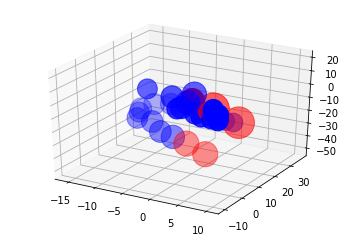

In [8]:
# Plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure, show

fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter( ms.cluster_centers_[:,0], ms.cluster_centers_[:,1], ms.cluster_centers_[:,2], s=size, c=colors )


7.828923720082757

In [2]:
# Library
from base import S2_CLUSTERS_FILE, S2_CLUSTER_ALGO_FILE
from pandas import read_csv, DataFrame
from numpy import array, percentile

# Constants
MAX_DISTANCE_QUANTILE = 85

# Read Data
centers_and_clusters:DataFrame = read_csv(S2_CLUSTERS_FILE)
cluster_labels:DataFrame = read_csv(S2_CLUSTER_ALGO_FILE)

labels = cluster_labels.index

# Compute Distances
cx = centers_and_clusters['centroid_x']
cy = centers_and_clusters['centroid_y']
cz = centers_and_clusters['centroid_z']

msx = centers_and_clusters['ms_x']
msy = centers_and_clusters['ms_y']
msz = centers_and_clusters['ms_z']

# Get Ready to plot
distances = DataFrame({
    'ms_dist': (((cx-msx)**2) + ((cy-msy)**2)  + ((cz-msz)**2))**0.5,
    'ms_middle': centers_and_clusters['ms_middle']
})
size = distances.groupby(['ms_middle'])['ms_dist'].max()

In [3]:
from numpy import where

cluster_ids = where( size > percentile(size, q = MAX_DISTANCE_QUANTILE) )[0].tolist()

,Unnamed: 0,triangle_idx,centroid_x,centroid_y,centroid_z,norm_x,norm_y,norm_z,ms_middle,ms_x,ms_y,ms_z
23533,15750,15750,-6.588817,19.773729,-43.271211,-0.054502,-0.010597,-3.222760e-02,15,-4.775539,21.915403,-45.922238
23534,15751,15751,-6.550154,19.681112,-43.304222,-0.027517,-0.006018,-1.721757e-02,15,-4.775539,21.915403,-45.922238
23535,15763,15763,-6.693865,20.051579,-43.113210,-0.077200,-0.003503,-3.331829e-02,15,-4.775539,21.915403,-45.922238
23536,15764,15764,-6.611027,20.051579,-43.285725,-0.066599,-0.003022,-3.573078e-02,15,-4.775539,21.915403,-45.922238
23537,15765,15765,-6.568161,19.958963,-43.351110,-0.054502,-0.005050,-3.222737e-02,15,-4.775539,21.915403,-45.922238
23538,15777,15777,-6.681795,20.334552,-43.105766,-0.083405,0.005214,-2.967408e-02,15,-4.775539,21.915403,-45.922238
23539,15778,15778,-6.609440,20.329430,-43.286722,-0.067431,0.004215,-3.090482e-02,15,-4.775539,21.915403,-45.922238
23540,15779,15779,-6.572364,20.236813,-43.366620,-0.066600,-0.000385,-3.573102e-02,15,-4.775539,21.915403,-45.922238
23541,15794,15794,-6.685496,20.521678,-43.014865,-0.080918,0.020316,-2.957038e-02,15,-4.775539,21.915403,-45.922238
23542,15795,15795,-6.631231,20.609173,-43.114924,-0.075771,0.015532,-2.405950e-02,15,-4.775539,21.915403,-45.922238
